In [26]:
import matplotlib.pyplot as plt
from abtem.parametrizations import LobatoParametrization
from ase.io import read
import numpy as np
import abtem
import sympy as sp
import json
from abtem.core.energy import energy2wavelength
%matplotlib ipympl


We would like to see if it's possible to apply importance sampling to the monte carlo solution of electron scattering. The equation we are going to use to help us determine what direction electrons should scatter to is:

$ \frac{d\sigma}{d\Omega} = |f(\theta)|^2 $

where $d\sigma$ is a differential element of the so called "cross section" $\sigma$, $d\Omega$ is a small patch of outgoing area (in units of steradians), and $f(\theta)$ is the so-called scattering amplitude. 

The total cross section ($\sigma$) describes the effective area of a collision, and has units of area. I think knowing $\sigma$ can help one calculate the probability of a scattering event happening in the first place, if one knows also the area over which an incoming beam of particles is spread. For the classical case of a hard sphere, the scattering cross section will be $\pi r ^ 2$.

I think one can describe a probability density function of scattering angles from a single atom by simply normalising $ |f(\theta)|^2 $

$$
P(\theta) = \frac{|f(\theta)|^2}{\sigma}
$$

I think this ensures that the probability density function integrates to one, though I am not sure. 

If one knows, $f(\theta)$, then we can find $\sigma$ by using the fact that:

- The total scattering cross section $\sigma$  is obtained by integrating the differential cross section over all solid angles:
   $$
   \sigma = \int_{0}^{2\pi} \int_{0}^{\pi} |f(\theta)|^2 \sin\theta \, d\theta \, d\phi
   $$

Recalling that $ d\Omega = sin(\theta) \ d\theta \ d\phi$

And in the case of round symmetry, no variable is a function of $\phi$, then 

   $$
   \sigma = 2 \pi \int_{0}^{\pi} |f(\theta)|^2 \sin(\theta) \ d\theta
   $$

And I think we can do all of this at least numerically for a single atom. 

**Step 1**:
Obtain function for $f(\theta)$, abtem should give us this easily. 

**Step 2**: Integrate: $\sigma = 2 \pi \int_{0}^{\pi} |f(\theta)|^2 \sin(\theta) \ d\theta$ to find normalisation factor. 

**Step 3**: Calculate $pdf(\theta) = \frac{|f(\theta)|^2}{\sigma}$ to obtain PDF of electron scattering to a certain direction. 

**Step 4**: Sample from this PDF to send electrons to a certain direction preferentially. 

In [27]:
# Using function from abtem to calculate scattering factor 
def scattering_factor_func(k2, p):
    return (
        (p[0, 0] * (2.0 + p[1, 0] * k2) / (1.0 + p[1, 0] * k2) ** 2)
        + (p[0, 1] * (2.0 + p[1, 1] * k2) / (1.0 + p[1, 1] * k2) ** 2)
        + (p[0, 2] * (2.0 + p[1, 2] * k2) / (1.0 + p[1, 2] * k2) ** 2)
        + (p[0, 3] * (2.0 + p[1, 3] * k2) / (1.0 + p[1, 3] * k2) ** 2)
        + (p[0, 4] * (2.0 + p[1, 4] * k2) / (1.0 + p[1, 4] * k2) ** 2)
    )


Let's start by plotting the scattering factor $f(\theta)$

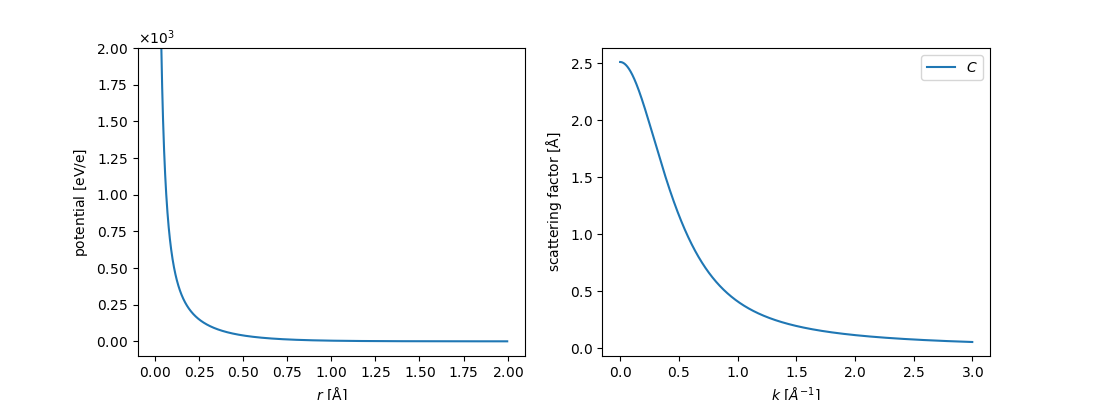

In [28]:
symbols = ["C"]

parametrization = LobatoParametrization()

potentials = parametrization.line_profiles(symbols, cutoff=2, name="potential")
scattering_factor = parametrization.line_profiles(
    symbols, cutoff=3, name="scattering_factor"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
visualization = potentials.show(ax=ax1, legend=False)
visualization.set_ylim([-1e2, 2e3])

scattering_factor.show(legend=True, ax=ax2);

And now let's convert the x-axis from $k$ space into angular space $\theta$. I think we can do this with the simple relation:

$\theta = k \lambda$

Text(0, 0.5, '$f \\ (\\theta)$ [Å]')

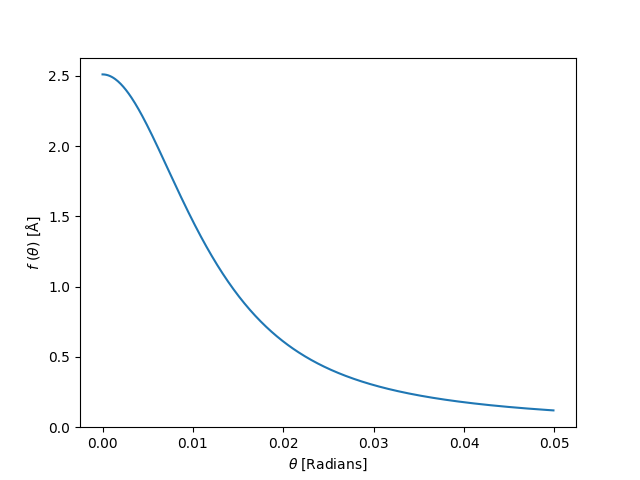

In [29]:
sampling = 1e-4
angular_cutoff = 0.05 #Must be radians?
wavelength = energy2wavelength(200000)

f = open('lobato.json') 
params = json.load(f)
atom_params = np.array(params['C'])

angles = np.arange(0, angular_cutoff, sampling)

k = angles / wavelength
k2 = k ** 2

f_theta = scattering_factor_func(k2, atom_params)

plt.figure()
plt.plot(angles, f_theta)
plt.xlabel('$\\theta$ [Radians]')
plt.ylabel('$f \\ (\\theta)$ [Å]')

Now we can simply solve $\sigma = 2 \pi \int_{0}^{\pi} |f(\theta)|^2 \sin(\theta) \ d\theta$ to find normalisation factor in sympy. We will ignore symbolic solutions to this for now. 

In [30]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

theta, lamb = sp.symbols('\\theta \lambda', real=True, positive=True)

a, b, c = sp.symbols('a b c', real=True)
f_theta = scattering_factor_func((theta / lamb) ** 2, atom_params)

# Define the integral for the total cross-section
sigma_integrand = 2 * np.pi * sp.Abs(f_theta)**2 * sp.sin(theta)

display(sigma_integrand)

6.28318530717959*(0.188154742603407*(-440.705714157926 - 507.996945709561*\theta**2/\lambda**2)/(0.433768074670563 + \theta**2/\lambda**2)**2 + 0.267485459489659*(-196.21587225396 - 189.694199116232*\theta**2/\lambda**2)/(0.517189964606487 + \theta**2/\lambda**2)**2 + (0.0284046082427246 + 0.0010921242638307*\theta**2/\lambda**2)/(1.0 + 0.0768976818478339*\theta**2/\lambda**2)**2 + 0.238297711219092*(390.470704560958 + 399.943391301618*\theta**2/\lambda**2)/(0.48815746559803 + \theta**2/\lambda**2)**2 + 0.17058295086619*(248.932177242686 + 301.358350805728*\theta**2/\lambda**2)/(0.413016889323173 + \theta**2/\lambda**2)**2)**2*sin(\theta)

and numerically solve for $\sigma$. 

0.0026088590416661534


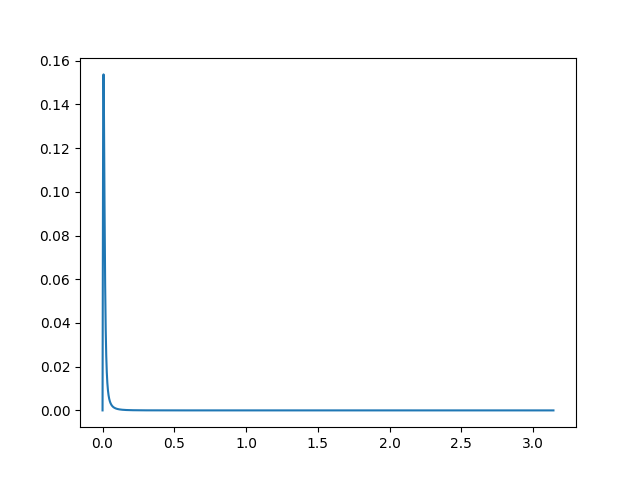

In [32]:
sigma_integrand_lambda = sp.lambdify([theta, lamb], sigma_integrand)

def integrand_with_wavelength(theta):
    return sigma_integrand_lambda(theta, wavelength)

theta_values = np.linspace(0, np.pi, 1000000)
plt.figure()
plt.plot(theta_values, integrand_with_wavelength(theta_values))

sigma_total, error = quad(integrand_with_wavelength, 0, np.pi)

print(sigma_total)

Next we need to find a way to sample the PDF

$$
pdf(\theta) = \frac{|f(\theta)|^2}{\sigma}
$$

To do this, we can use the CDF $ F(\theta) $ which for each value of $\theta$ is found by solving the following integral, and gives us the cumulative probability up to $\theta$:

$$
F(\theta) = \frac{1}{\sigma} \int_{\theta_0}^{\theta} |f(\theta')|^2 \, d\theta'
$$


- $ \theta' $ is a dummy variable of integration.
- $ \theta_0 $ is the lower bound of the angle range (often 0 or some minimum angle depending on the context).
- $ \theta $ is the upper limit up to which we are integrating to find the cumulative probability.

This integral gives the CDF, which represents the probability that the scattering angle is less than or equal to $\theta$.

Once we have the CDF, we can then sample from that uniformly by using inverse transform sampling. By drawing uniform random numbers, and putting them into the inverse CDF function, we can I think generate samples with the right probabilistic proportion.

Apparently this works although I don't know why or how. 

In [40]:
f_theta2_lambda = sp.lambdify([theta, lamb], sp.Abs(f_theta)**2)

def ftheta2_with_wavelength(theta):
    return f_theta2_lambda(theta, wavelength)

def pdf(theta):
    return integrand_with_wavelength(theta) / sigma_total

theta_values = np.linspace(0, np.pi, 10000)

# plt.figure()
# plt.plot(theta_values, pdf(theta_values))

print(quad(pdf, 0, np.pi))


(1.0000000000000373, 1.1441219273825347e-14)


In [ ]:

# Step 7: Compute the CDF by numerically integrating the PDF
cdf_values = np.array([quad(pdf, 0, t)[0] for t in np.linspace(0, np.pi, 1000)])
theta_values = np.linspace(0, np.pi, 1000)
cdf_values /= cdf_values[-1]  # Norm

# plt.figure()
# plt.plot(theta_values, pdf(theta_values))

# plt.figure()
# plt.plot(theta_values, cdf_values)

print(cdf_values[-1])

inverse_cdf = interp1d(cdf_values, theta_values)

# Step 9: Sample from the inverse CDF
def sample_theta(n_samples):
    random_values = np.random.uniform(0, 1, n_samples)
    return inverse_cdf(random_values)

# plt.figure()
# plt.plot(cdf_values, theta_values)

# Example: Sample 10 angles
sampled_angles = sample_theta(1000)
print(f"Sampled angles: {sampled_angles}")

# plt.figure()
# plt.hist(sampled_angles)

In [ ]:

# Step 7: Compute the CDF by numerically integrating the PDF
cdf_values = np.array([quad(pdf, 0, t)[0] for t in np.linspace(0, np.pi, 1000)])
theta_values = np.linspace(0, np.pi, 1000)
cdf_values /= cdf_values[-1]  # Norm

# plt.figure()
# plt.plot(theta_values, pdf(theta_values))

# plt.figure()
# plt.plot(theta_values, cdf_values)

print(cdf_values[-1])

inverse_cdf = interp1d(cdf_values, theta_values)

# Step 9: Sample from the inverse CDF
def sample_theta(n_samples):
    random_values = np.random.uniform(0, 1, n_samples)
    return inverse_cdf(random_values)

# plt.figure()
# plt.plot(cdf_values, theta_values)

# Example: Sample 10 angles
sampled_angles = sample_theta(1000)
print(f"Sampled angles: {sampled_angles}")

# plt.figure()
# plt.hist(sampled_angles)